<a href="https://colab.research.google.com/github/suchig/Intel-Image-Classification/blob/master/Image_Classification_Intel_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification of Intel images

---

Downloading files from Kaggle

In [0]:
#Below to be done to download data from Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip
!rm intel-image-classification.zip
!unzip seg_train.zip -d /tmp
!rm seg_train.zip
!unzip seg_test.zip -d /tmp
!rm seg_test.zip
!rm seg_pred.zip

In [0]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import argmax
from tensorflow.math import confusion_matrix as cm
import tensorflow as tf

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import numpy as np
from pathlib import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Analysis of images

To start, t-sne can be run to see if there is any distinct similarity between classes

In [0]:
images = []
y=[]
i=-1
sprite=[]

for path in os.listdir('/tmp/seg_test'):
  i += 1
  
  for f in os.listdir('/tmp/seg_test'+"/"+ path):
    
    image_array = image.load_img(str('/tmp/seg_test'+"/"+ path+"/"+f),target_size=(150,150,3))
    sprite_image = image_array.resize((64,64))
    image_array = image.img_to_array(image_array)
    
    images.append(image_array.ravel())
    sprite.append(image.img_to_array(sprite_image))
    y.append(i)

images = np.asarray(images)
sprite = np.asarray(stripe)

In [0]:
def tsne_scatter(x, y):  
    # create a scatter plot.
    plt.figure(figsize=(14, 14))
    plt.scatter(x[:,0], x[:,1],c=y,cmap=plt.cm.get_cmap("jet", 6)) 
    plt.colorbar(ticks=range(6)).set_ticklabels(
        ["buildings","forest","glacier","mountain","sea","street"])
    plt.axis('off')

In [0]:
tsne_vector = TSNE(random_state=127).fit_transform(np.asarray(images))

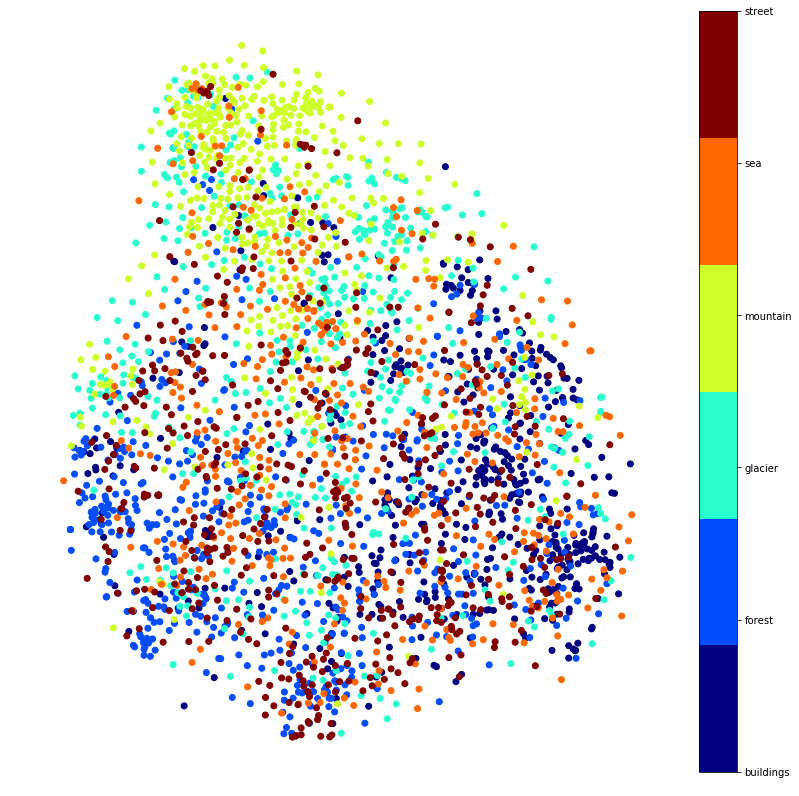

In [0]:
tsne_scatter(tsne_vector,y)

From the above it looks like the segmentations are not very distingushable. This means there could be multiple similarities. One possible pattern that is seen here - **glaciers and mountains seem to be placed next to each other** possibly these could share similar features.


---
Different architectures of convolution is tried out to classify the images.

#Different Architectures
Before the start of trials, image generator for Training and Validation are created


In [0]:
#Simple CNN, no augmentation
TRAINING_DIR = "/tmp/seg_train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    batch_size = 100,
    class_mode='categorical')
    

VALIDATION_DIR = "/tmp/seg_test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size = 50,
    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Function to plot accuracy and loss between Training and Validation

In [0]:
# PLOT LOSS AND ACCURACY
def plot_acc_loss(history, relative=True):
  acc=history.history['acc']
  val_acc=history.history['val_acc']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) 

  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])
  plt.title('Training and validation accuracy')
  if relative==False:
    plt.yticks(np.arange(0, 1, step=0.05))
  plt.figure()

  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])
  plt.title('Training and validation loss')
  if relative==False:
    y_max = max(loss) if max(loss)>max(val_loss) else max(val_loss)
    y_max = 1 if y_max < 1 else y_max
    plt.yticks(np.arange(0, y_max, step=0.05))
  plt.figure()

---
**1. Baseline model of one CONV, POOL and FULL layer**


In [0]:
model1 = Sequential([
    Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(6,activation='softmax')
])

model1.compile(loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

In [0]:
history1 = model1.fit_generator(train_generator,
                              steps_per_epoch=140,
                              epochs=10,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)
model1.save("model1")

Epoch 1/10
140/140 [==============================] - 47s 335ms/step - loss: 3.4639 - acc: 0.5546 - val_loss: 0.8638 - val_acc: 0.6867
Epoch 2/10
140/140 [==============================] - 24s 172ms/step - loss: 0.6411 - acc: 0.7747 - val_loss: 0.7624 - val_acc: 0.7270
Epoch 3/10
140/140 [==============================] - 24s 170ms/step - loss: 0.4419 - acc: 0.8532 - val_loss: 0.8109 - val_acc: 0.7157
Epoch 4/10
140/140 [==============================] - 24s 171ms/step - loss: 0.2772 - acc: 0.9188 - val_loss: 0.7586 - val_acc: 0.7520
Epoch 5/10
140/140 [==============================] - 24s 172ms/step - loss: 0.1796 - acc: 0.9544 - val_loss: 0.7790 - val_acc: 0.7463
Epoch 6/10
140/140 [==============================] - 24s 172ms/step - loss: 0.1124 - acc: 0.9763 - val_loss: 0.8249 - val_acc: 0.7513
Epoch 7/10
140/140 [==============================] - 24s 172ms/step - loss: 0.0726 - acc: 0.9866 - val_loss: 0.8680 - val_acc: 0.7520
Epoch 8/10
140/140 [==============================] - 2

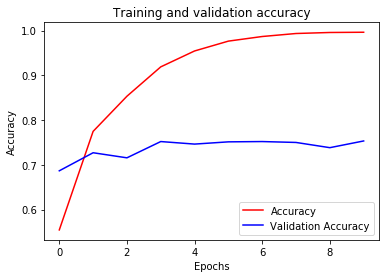

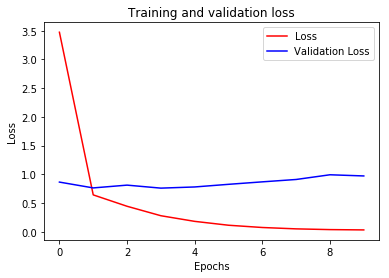

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history1)

Observation: Even though baseline model took the accuracy of Training to near 99%, the accuracy of Validation could only reach 75%. This shows overfitting of data.

**2. Two CONV/ BatchNormalization/POOL and FULL**

In [0]:
model3 = Sequential([
    Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    BatchNormalization(),
    AveragePooling2D(),
    Conv2D(32,(3,3),activation='relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(6,activation='softmax')
])

model3.compile(loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

history3 = model3.fit_generator(train_generator,
                              steps_per_epoch=140,
                              epochs=25,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)

Epoch 1/25
140/140 [==============================] - 50s 354ms/step - loss: 2.1187 - acc: 0.6051 - val_loss: 2.0662 - val_acc: 0.2340
Epoch 2/25
140/140 [==============================] - 26s 186ms/step - loss: 0.8304 - acc: 0.7490 - val_loss: 2.8624 - val_acc: 0.4270
Epoch 3/25
140/140 [==============================] - 26s 186ms/step - loss: 0.4540 - acc: 0.8403 - val_loss: 1.9388 - val_acc: 0.4893
Epoch 4/25
140/140 [==============================] - 26s 188ms/step - loss: 0.2528 - acc: 0.9101 - val_loss: 1.0486 - val_acc: 0.7040
Epoch 5/25
140/140 [==============================] - 26s 188ms/step - loss: 0.1762 - acc: 0.9407 - val_loss: 1.0111 - val_acc: 0.7490
Epoch 6/25
140/140 [==============================] - 26s 187ms/step - loss: 0.1266 - acc: 0.9584 - val_loss: 1.0734 - val_acc: 0.7453
Epoch 7/25
140/140 [==============================] - 26s 188ms/step - loss: 0.1024 - acc: 0.9672 - val_loss: 1.7104 - val_acc: 0.6770
Epoch 8/25
140/140 [==============================] - 2

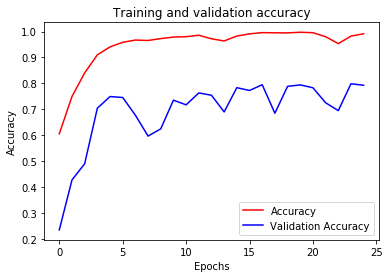

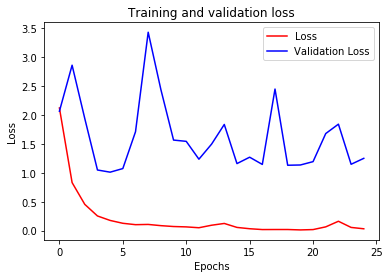

<Figure size 432x288 with 0 Axes>

In [0]:
model3.save("model3")
plot_acc_loss(history3)

It can be seen from above models and performances that increasing complexity could help with better accuracy and adding Dropout could help with balancing overfitting.




**3. (2xCONV/Pool/Dropout)x3 + 2xFULL (Filter size increased)**

In [0]:
model6 = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    
    Conv2D(64,(3,3),activation='relu'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    
    Conv2D(128,(3,3),activation='relu'),
    Conv2D(256,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(1024,activation='relu'),
    Dropout(0.25),
    
    Dense(512,activation='relu'),
    Dropout(0.25),
    
    Dense(6,activation='softmax')
])

model6.compile(loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

history6 = model6.fit_generator(train_generator,
                              steps_per_epoch=140,
                              epochs=15,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)
model6.save("model6")

Epoch 1/15
140/140 [==============================] - 114s 812ms/step - loss: 1.2389 - acc: 0.5055 - val_loss: 1.0511 - val_acc: 0.5547
Epoch 2/15
140/140 [==============================] - 87s 623ms/step - loss: 0.8728 - acc: 0.6400 - val_loss: 0.7664 - val_acc: 0.6797
Epoch 3/15
140/140 [==============================] - 87s 624ms/step - loss: 0.7650 - acc: 0.6935 - val_loss: 0.7017 - val_acc: 0.7257
Epoch 4/15
140/140 [==============================] - 87s 624ms/step - loss: 0.6538 - acc: 0.7502 - val_loss: 0.6198 - val_acc: 0.7613
Epoch 5/15
140/140 [==============================] - 87s 624ms/step - loss: 0.5549 - acc: 0.7950 - val_loss: 0.5625 - val_acc: 0.7933
Epoch 6/15
140/140 [==============================] - 87s 624ms/step - loss: 0.4986 - acc: 0.8198 - val_loss: 0.5624 - val_acc: 0.7970
Epoch 7/15
140/140 [==============================] - 87s 624ms/step - loss: 0.4494 - acc: 0.8331 - val_loss: 0.5286 - val_acc: 0.8077
Epoch 8/15
140/140 [==============================] - 

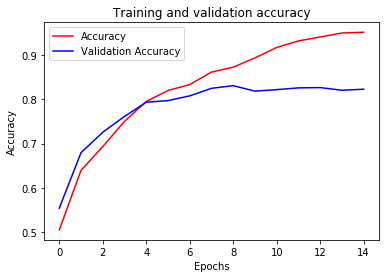

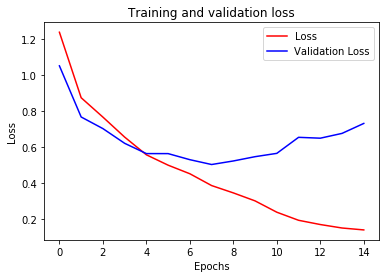

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history6)

Since all the trials almost always had overfitting, it is time to try Image augmentation. 

---
#Image Augmentation

Note that batch size of Training is reduced so that there is no memory crash



In [0]:
#Simple CNN, no augmentation
TRAINING_DIR = "/tmp/seg_train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode="nearest")
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    batch_size = 50,
    class_mode='categorical')

VALIDATION_DIR = "/tmp/seg_test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size = 50,
    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**4. Complex architecture of CONV/POOL/Dropout + 3 FULL**

Also added a learning rate of 0.0001 for Optimzer

In [0]:
model7 = Sequential([
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    
    Conv2D(128,(3,3),activation='relu'),
    Conv2D(100,(3,3),activation='relu'),
    Conv2D(72,(3,3),activation='relu'),
    Conv2D(50,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(512,activation='relu'),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dropout(0.5),
    
    Dense(6,activation='softmax')
])
import tensorflow.keras.optimizers as Optimizer
model7.compile(loss='categorical_crossentropy',
    optimizer=Optimizer.Adam(lr=0.0001),
    metrics=['accuracy'])

history7 = model7.fit_generator(train_generator,
                              steps_per_epoch=int(14034/50),
                              epochs=30,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)
model7.save("model7")

W0730 02:17:30.609559 139891323864960 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30
280/280 [==============================] - 333s 1s/step - loss: 1.2882 - acc: 0.4840 - val_loss: 1.0405 - val_acc: 0.5903
Epoch 2/30
280/280 [==============================] - 313s 1s/step - loss: 1.0724 - acc: 0.5845 - val_loss: 0.8582 - val_acc: 0.6690
Epoch 3/30
280/280 [==============================] - 313s 1s/step - loss: 0.9679 - acc: 0.6343 - val_loss: 0.7148 - val_acc: 0.7340
Epoch 4/30
280/280 [==============================] - 313s 1s/step - loss: 0.8917 - acc: 0.6694 - val_loss: 0.7250 - val_acc: 0.7367
Epoch 5/30
280/280 [==============================] - 313s 1s/step - loss: 0.8423 - acc: 0.6924 - val_loss: 0.6377 - val_acc: 0.7703
Epoch 6/30
280/280 [==============================] - 313s 1s/step - loss: 0.7784 - acc: 0.7136 - val_loss: 0.6335 - val_acc: 0.7740
Epoch 7/30
280/280 [==============================] - 313s 1s/step - loss: 0.7499 - acc: 0.7285 - val_loss: 0.6441 - val_acc: 0.7637
Epoch 8/30
280/280 [==============================] - 313s 1s/step - 

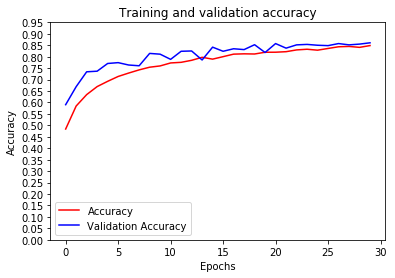

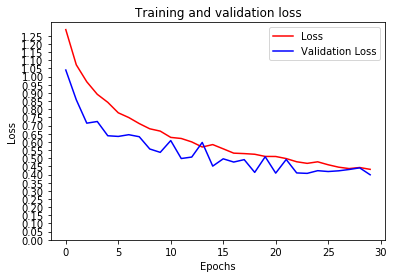

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history7,relative=False)

It is clear that the more complex the architecture the better the accuracy. This is a good time to try Transfer Learning. The batch size of Image Generator can be increased now for faster processing

In [0]:
TRAINING_DIR = "/tmp/seg_train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode="nearest")
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    batch_size = 100,
    class_mode='categorical')

VALIDATION_DIR = "/tmp/seg_test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size = 50,
    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


---
#Transfer Learning 
**5. Inception V3**

In [0]:
pre_trained_model10 = InceptionV3(input_shape=(150,150,3),
                                 include_top=False)
for layer in pre_trained_model10.layers[:300]:
  layer.trainable=False
  
model10 = Sequential([
    pre_trained_model10,
    GlobalAveragePooling2D(),
    Dense(4096,activation='relu'),
    Dense(2048,activation='relu'),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
])


model10.compile(loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

history10 = model10.fit_generator(train_generator,
                              int(14034/100),
                              epochs=40,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)
model10.save("model10")

Epoch 1/40
280/280 [==============================] - 122s 434ms/step - loss: 0.9712 - acc: 0.6350 - val_loss: 0.7231 - val_acc: 0.7750
Epoch 2/40
280/280 [==============================] - 111s 396ms/step - loss: 0.7241 - acc: 0.7353 - val_loss: 0.6792 - val_acc: 0.7850
Epoch 3/40
280/280 [==============================] - 110s 392ms/step - loss: 0.6823 - acc: 0.7486 - val_loss: 0.7616 - val_acc: 0.7723
Epoch 4/40
280/280 [==============================] - 109s 391ms/step - loss: 0.6560 - acc: 0.7635 - val_loss: 0.6393 - val_acc: 0.8033
Epoch 5/40
280/280 [==============================] - 110s 393ms/step - loss: 0.6491 - acc: 0.7577 - val_loss: 0.6790 - val_acc: 0.7850
Epoch 6/40
280/280 [==============================] - 110s 393ms/step - loss: 0.6291 - acc: 0.7687 - val_loss: 0.7186 - val_acc: 0.7673
Epoch 7/40
280/280 [==============================] - 111s 395ms/step - loss: 0.6271 - acc: 0.7673 - val_loss: 0.7676 - val_acc: 0.7880
Epoch 8/40
280/280 [============================

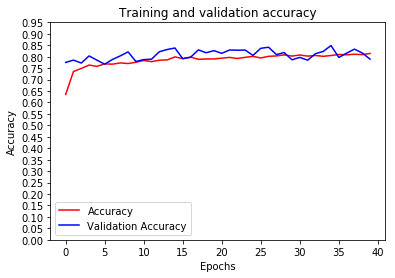

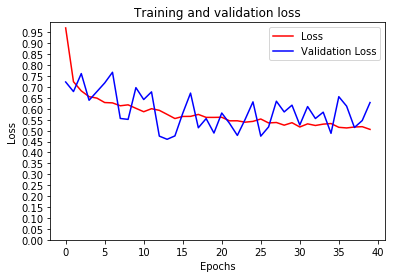

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history10,relative=False)

Observation: Accuracy of Inception is around 81% and Validation loss line is not smooth.

**6. MobileNet**

In [0]:
pre_trained_model_11 = MobileNet(input_shape=(150,150,3),
             include_top=False)
model11 = Sequential([
    
    pre_trained_model_11,
    GlobalAveragePooling2D(),
    Dense(4096,activation='relu'),
    Dense(2048,activation='relu'),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
])
model11.layers[0].trainable = False
model11.compile(loss='categorical_crossentropy',
    optimizer=Optimizer.Adam(lr=0.0001),
    metrics=['accuracy'])

history11 = model11.fit_generator(train_generator,
                              steps_per_epoch=int(14034/100),
                              epochs=40,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)

Epoch 1/40
280/280 [==============================] - 111s 397ms/step - loss: 0.6353 - acc: 0.7655 - val_loss: 0.4239 - val_acc: 0.8510
Epoch 2/40
280/280 [==============================] - 98s 349ms/step - loss: 0.4671 - acc: 0.8294 - val_loss: 0.4355 - val_acc: 0.8370
Epoch 3/40
280/280 [==============================] - 98s 350ms/step - loss: 0.4307 - acc: 0.8417 - val_loss: 0.3739 - val_acc: 0.8503
Epoch 4/40
280/280 [==============================] - 99s 353ms/step - loss: 0.4180 - acc: 0.8483 - val_loss: 0.4319 - val_acc: 0.8393
Epoch 5/40
280/280 [==============================] - 130s 466ms/step - loss: 0.3849 - acc: 0.8566 - val_loss: 0.4013 - val_acc: 0.8597
Epoch 6/40
280/280 [==============================] - 97s 347ms/step - loss: 0.3762 - acc: 0.8626 - val_loss: 0.3750 - val_acc: 0.8660
Epoch 7/40
280/280 [==============================] - 97s 346ms/step - loss: 0.3600 - acc: 0.8670 - val_loss: 0.4121 - val_acc: 0.8450
Epoch 8/40
280/280 [==============================] -

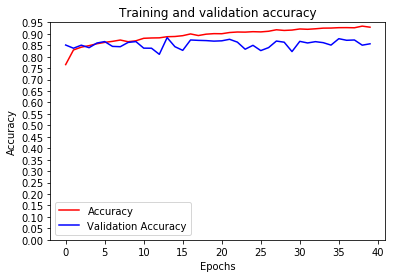

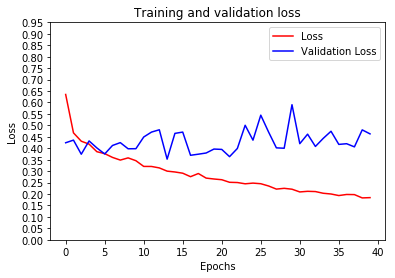

<Figure size 432x288 with 0 Axes>

In [0]:
model11.save("model11")
plot_acc_loss(history11,relative=False)

Observation: While the accuracy of MobileNet went as high as 90%, there is no droop in Validation loss.

**7. VGG**

In [0]:
pre_trained_model_12 = VGG19(input_shape=(150,150,3),include_top=False)

model12 = Sequential([
    
    pre_trained_model_12,
    GlobalAveragePooling2D(),
    Dense(4096,activation='relu'),
    Dense(2048,activation='relu'),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
])
model12.layers[0].trainable = False
model12.compile(loss='categorical_crossentropy',
    optimizer=Optimizer.Adam(lr=0.0001),
    metrics=['accuracy'])

In [0]:
history12 = model12.fit_generator(train_generator,
                              steps_per_epoch=int(14034/50),
                              epochs=40,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)

Epoch 1/40
280/280 [==============================] - 149s 534ms/step - loss: 0.8221 - acc: 0.6771 - val_loss: 0.5095 - val_acc: 0.8113
Epoch 2/40
280/280 [==============================] - 132s 470ms/step - loss: 0.6018 - acc: 0.7692 - val_loss: 0.4700 - val_acc: 0.8260
Epoch 3/40
280/280 [==============================] - 131s 468ms/step - loss: 0.5604 - acc: 0.7865 - val_loss: 0.4410 - val_acc: 0.8263
Epoch 4/40
280/280 [==============================] - 131s 468ms/step - loss: 0.5239 - acc: 0.8047 - val_loss: 0.4194 - val_acc: 0.8490
Epoch 5/40
280/280 [==============================] - 131s 468ms/step - loss: 0.5151 - acc: 0.8046 - val_loss: 0.3986 - val_acc: 0.8477
Epoch 6/40
280/280 [==============================] - 131s 468ms/step - loss: 0.4929 - acc: 0.8119 - val_loss: 0.4105 - val_acc: 0.8443
Epoch 7/40
280/280 [==============================] - 130s 466ms/step - loss: 0.4905 - acc: 0.8129 - val_loss: 0.4121 - val_acc: 0.8403
Epoch 8/40
280/280 [============================

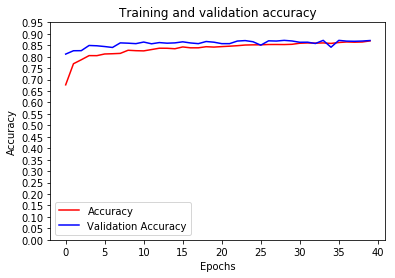

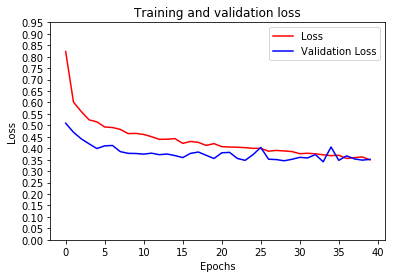

<Figure size 432x288 with 0 Axes>

In [0]:
model12.save("model12")
plot_acc_loss(history12,relative=False)

Observation: Accuracy is around 86% and loss of both Training and Validation is converging. **This seems like the best model.**


---

# Final Recommendation


**100 Epochs using VGG**

In [0]:
history13 = model12.fit_generator(train_generator,
                              steps_per_epoch=int(14034/100),
                              epochs=100,
                              verbose=1,
                              validation_steps=60,
                              validation_data=validation_generator)

Epoch 1/100
140/140 [==============================] - 140s 1s/step - loss: 0.8954 - acc: 0.6516 - val_loss: 0.5516 - val_acc: 0.7923
Epoch 2/100
140/140 [==============================] - 129s 921ms/step - loss: 0.6256 - acc: 0.7605 - val_loss: 0.4681 - val_acc: 0.8273
Epoch 3/100
140/140 [==============================] - 132s 942ms/step - loss: 0.5853 - acc: 0.7792 - val_loss: 0.4417 - val_acc: 0.8407
Epoch 4/100
140/140 [==============================] - 127s 909ms/step - loss: 0.5489 - acc: 0.7947 - val_loss: 0.4449 - val_acc: 0.8340
Epoch 5/100
140/140 [==============================] - 131s 933ms/step - loss: 0.5282 - acc: 0.8014 - val_loss: 0.4444 - val_acc: 0.8293
Epoch 6/100
140/140 [==============================] - 125s 890ms/step - loss: 0.5151 - acc: 0.8044 - val_loss: 0.4085 - val_acc: 0.8530
Epoch 7/100
140/140 [==============================] - 125s 893ms/step - loss: 0.5059 - acc: 0.8097 - val_loss: 0.4245 - val_acc: 0.8407
Epoch 8/100
140/140 [=======================

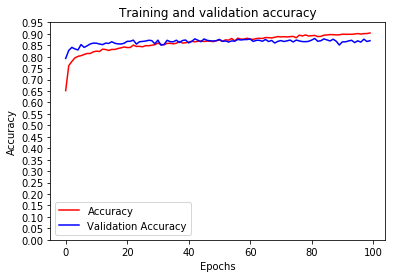

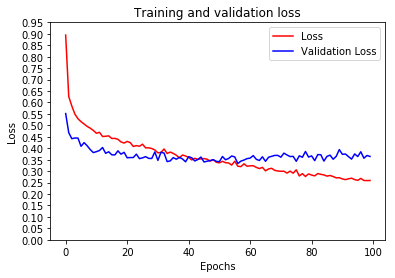

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history13,relative=False)

In [0]:
model12.save("model12")

Observation: Accuracy has boosted to 90% and loss of Validation is diverging a little from that of training. This still seems bearable and model of choice for Image Classification

**Confusion Matrix and Accuracy**

When creating ImageGenerator for evaluation, it is crucial to set Shuffle as False to map the predicted values against actual properly.

In [0]:
eval_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size = 50,
    class_mode='categorical',
    shuffle=False)

predict_val = model12.predict_generator(eval_generator)

#Since confusion matrix function will accept only in label form
#argmax has to be called
predict_val = argmax( predict_val, 1 )

Found 3000 images belonging to 6 classes.


array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

Function to draw confusion matrix

In [0]:
def plot_confusion_matrix(cm):
    
    classnames = ["buildings","forest","glacier","mountain","sea","street"]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm,cmap="viridis");
    plt.xticks(np.arange(cm.shape[1]),classnames, rotation=45)
    plt.yticks(np.arange(cm.shape[0]),classnames)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
          plt.text(j,i, cm[i,j],ha="center", va="center",
                   color="white" if cm[i, j] < 100 else "black")
    plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


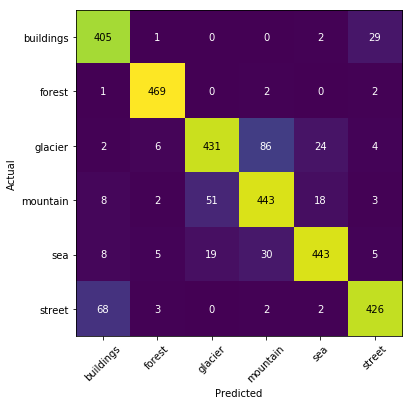

In [0]:
cm_tensor = cm(validation_generator.labels,predict_val,num_classes=6)
sess = tf.InteractiveSession()
plot_confusion_matrix(cm_tensor.eval())

In [0]:
sess.close()

Observation:

**Accuracy is nearly 88%**

Significant portion of errors are seen between
- Mountain and glacier (This was earlier observed during t-SNE analysis) perhaps because they share the same features. And possibly the model could misunderstand snow clad mountains to be glaciers and vice versa.
- Similar anomaly is found between buildings and streets, perhaps because the images would share features of horizontal and vertical lines.